## Programming Exercise 8: Anomaly Detection and Recommender Systems

In [26]:
import warnings,os
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from scipy.io import loadmat

### 1&nbsp;&nbsp;&nbsp;&nbsp;Anomaly detection

#### Problem Statement
In this part of the exercise, we will implement an anomaly detection algorithm to detect the anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While our servers were operating, we collected m=307 examples of how they were behaving, and thus have an unlabeled dataset. We suspect that the vast majority of these examples are "Normal" (Non-anomalous) examples of servers operating normally, but there might also be some examples of servers acting anomalously within the dataset.

**We will use a gaussian model to detect the anomalies in our dataset. On this dataset, we will fit a gaussian distribution and then find the values that have very low probability and hence can be considered anomalies.**

In [27]:
# Loading dataset
mat=loadmat('../DataSets/Exercise-8/ex8data1.mat')
X=mat['X']
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
Xval
yval


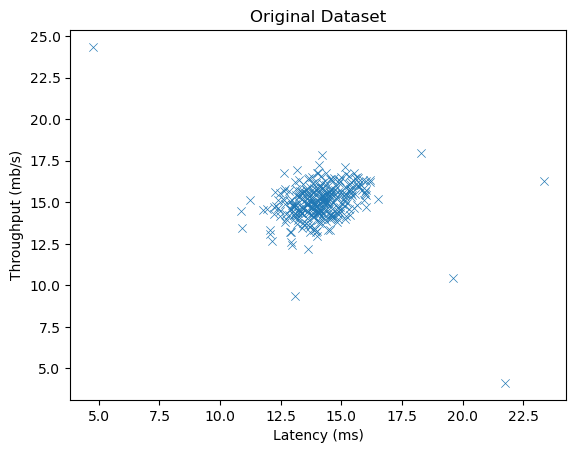

In [28]:
fig=sns.scatterplot(x=X[:,0],y=X[:,1],marker='x')
fig.set(xlabel='Latency (ms)',ylabel='Throughput (mb/s)',title='Original Dataset');

#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Gaussian Distribution
To perform anomaly detection, we will first need to fit a model to the data's distribution.  
Given a training set, we want to estimate the gaussian distribution for each of the features. For each feature, we need to find the parameters $\mu_{i}$ and $\sigma_{i}^{2}$ that fit the data. The gaussian distribution is given by:

$$\boxed{p(x_{j};\mu_{j},\sigma_{j}^{2})=\frac{1}{\sqrt{2\pi\sigma_{j}^{2}}}e^{-\frac{(X_{j}-\mu_{j})^{2}}{2\sigma_{j}^{2}}}}$$

$$p(x)=\Pi_{j=1}^{n}p(x_{j};\mu_{j},\sigma_{j}^{2})$$

$$\text{Anomaly, if }p(x)< \varepsilon$$

In [29]:
def mutlivariateGaussian(X,mu,sigma):
    p=(1/(np.sqrt(2*np.pi*np.power(sigma,2))))*np.exp(-np.power(X-mu,2)/(2*np.power(sigma,2)))
    p=np.product(p,axis=1).reshape((-1,1))
    return p

#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;Estimating parameters for a Gaussian
We can estimate the parameters ($\mu_{i},\sigma_{i}^{2}$) of the i-th feature by using the following equations. To estimate the mean, we will use
$$\mu_{i}=\frac{1}{m}\sum_{j=1}^{m}x_{i}^{(j)}$$

And for the variance, we will use:
$$\sigma_{i}^{2}=\frac{1}{m}\sum_{j=1}^{m}(x_{i}^{(j)}-\mu_{i})^2$$

In [30]:
def estimateGaussian(X):
    mu=np.mean(X,axis=0)
    sigma=np.std(X,axis=0)
    return (mu,sigma)

Let's look at the Gaussian distribution contours of the distribution fit to the dataset.

In [31]:
def plotGaussianContour(X,mu,sigma,title=None):
    # Constructing grid around the min and max range of original data
    temp=np.linspace(np.min(X)-5,np.max(X)+5)
    [x1,x2]=np.meshgrid(temp,temp)
    # Computing the Gaussian Density Probability for the grid
    temp=np.array([x1.reshape(-1),x2.reshape(-1)]).T
    z=mutlivariateGaussian(temp,mu,sigma).reshape(x1.shape)
    # Plotting
    levels=np.power(10,list(map(lambda x:float(x),list(range(-20,0,3)))))
    plt.contour(x1,x2,z,levels=levels);
    fig=sns.scatterplot(x=X[:,0],y=X[:,1],marker='x')
    title='Gaussian Distribution Contours' if title==None else title
    fig.set(xlabel='Latency (ms)',ylabel='Throughput (mb/s)',title=title);

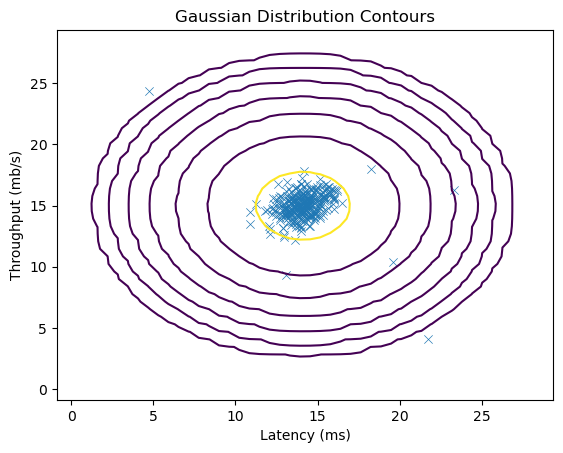

In [32]:
# Estimating Gaussian parameters
mu,sigma=estimateGaussian(X)
# Computing Density Probability
p=mutlivariateGaussian(X,mu,sigma)
# Plotting
plotGaussianContour(X,mu,sigma);

#### 1.3&nbsp;&nbsp;&nbsp;&nbsp;Selecting the threshold, $\varepsilon$
Now that we have estimated the gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are the anomalies is to select the threshold based on a cross validation set. In this part of the exericse, we will implement an algorithm to select the threshold using F1 score on a cross validation set.  

**$y=1$ corresponds to an anomalous examples and $y=0$ corresponds to a normal examples.**

In [33]:
Xval=mat['Xval']
yval=mat['yval']

For many different values of $\varepsilon$, we will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly. The $F_1$ score is computed using **Precision** (prec) and **Recall** (rec):

$$\boxed{F1=\frac{2.prec.rec}{prec+rec}}$$

We can compute Precision (prec) and Recall (rec) using:

$$\boxed{prec=\frac{tp}{tp+fp}}$$

$$\boxed{rec=\frac{tp}{tp+fn}}$$

where,
- $tp$ is the number of true positives: the ground truth label says it's an anomaly and our algorithm classified it as an anomaly.
- $fp$ is the number of false positives: the ground truth label says it's not an anomaly and our algorithm classified it as  an anomaly.
- $fn$ is the number of false negatives: the ground truth labels says it's an anomaly and our alogrithm classified it as not being anomalous.

In [34]:
def selectThreshold(yval,pval):
    '''
     Returns the threshold value of epsilon and the corresponding F1 score.
    '''
    bestEpsilon=bestF1=F1=0
    epsilons=np.linspace(np.min(pval),np.max(pval),1000)
    for epsilon in epsilons:
        cvPrediction=pval<epsilon
        tp=np.sum((cvPrediction==1) & (yval==1))
        fp=np.sum((cvPrediction==1) & (yval==0))
        fn=np.sum((cvPrediction==0) & (yval==1))
        prec=rec=0
        # Computing Precision
        if tp+fp>0:
            prec=tp/(tp+fp)
        # Computing Recall
        if tp+fn>0:
            rec=tp/(tp+fn)
        # Computing F1 Score
        if prec+rec>0:
            F1=(2*prec*rec)/(prec+rec)
        if F1>bestF1:
            bestF1=F1
            bestEpsilon=epsilon
    return (bestEpsilon,bestF1)

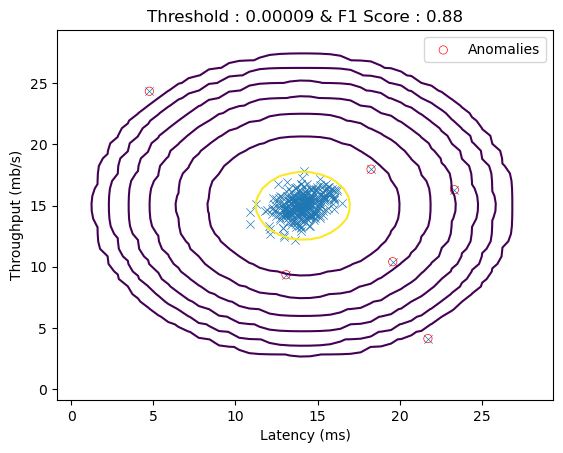

In [35]:
# Using sample mean and std. to compute density probability for cross validation set
pval=mutlivariateGaussian(Xval,mu,sigma)
# Calculating the threshold based on the best F1 Score
epsilon,f1=selectThreshold(yval,pval)
# Getting indices for anomalous examples
indices=np.where((p<epsilon)==True)[0]
# Plotting anomalies
title=f'Threshold : {epsilon:.5f} & F1 Score : {f1:.2f}'
plotGaussianContour(X,mu,sigma,title=title)
sns.scatterplot(x=X[indices,0],y=X[indices,1],marker='o',facecolors='none',edgecolor='r',label='Anomalies');

#### 1.4&nbsp;&nbsp;&nbsp;&nbsp;High Dimensional Dataset
In this dataset, each example is described by 11 features, caputring many more properties of our compute servers.

In [36]:
# Loading dataset
mat=loadmat('../DataSets/Exercise-8/ex8data2.mat')
X=mat['X']
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
Xval
yval


In [37]:
pd.DataFrame(X).sample(5)

,0,1,2,3,4,5,6,7,8,9,10
557,-13.484742,-16.207376,12.298756,-22.746703,-15.238110,6.229997,-20.745100,1.762533,-5.796397,4.072867,12.240402
69,-2.665572,-1.793277,-3.312666,-11.771151,-22.948824,0.657702,4.040898,2.684116,-4.217029,-12.993472,6.657632
53,20.034504,-8.874773,16.004579,-9.744514,0.262711,-3.748368,-12.963468,0.590094,-15.512008,3.285388,14.605712
92,10.723111,-4.492009,15.967817,-3.855716,-6.046074,30.804600,3.318897,11.751648,-1.820406,-5.464692,9.595698
542,2.824033,-20.838926,22.715974,-9.646891,-11.321469,3.868433,-2.015752,6.367652,1.306460,1.549635,10.245372


#### Principal Component Analysis (Optional)

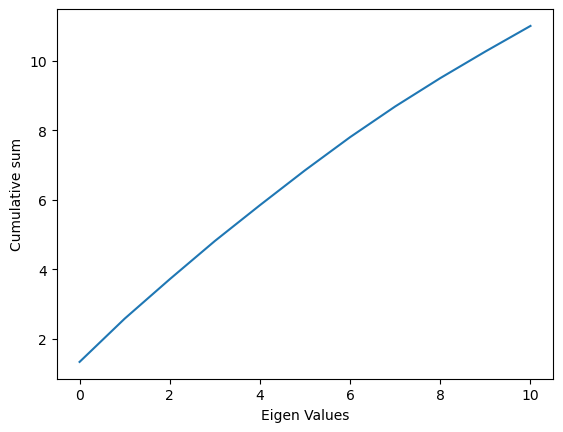

In [38]:
# Centering and scaling the data matrix
xPCA=(X-X.mean(axis=0))/X.std(axis=0)
# Computing Covariance
C=np.cov(xPCA.T)
# Computing eigenvalues and eigenvectors
eigenValues,eigenVectors=np.linalg.eig(C)
# Sorting eigenvalues in descending order
idx=eigenValues.argsort()[::-1]
eigenValues=eigenValues[idx]
eigenVectors=eigenVectors[idx]

# Plotting elbow curve
chart=sns.lineplot(x=list(range(len(eigenValues))),y=np.cumsum(eigenValues));
chart.set(xlabel='Eigen Values',ylabel='Cumulative sum');

Looking at the graph above, we can conclude that most of the singular values matter for this dataset.

#### Finding Anomalies

In [39]:
# Computing Gaussian Parameters
mu,sigma=estimateGaussian(X)
p=mutlivariateGaussian(X,mu,sigma)

In [40]:
# Using Cross Validation set to select a threshold
Xval=mat['Xval']
yval=mat['yval']
# Computing density probability
pval=mutlivariateGaussian(Xval,mu,sigma)
epsilon,f1=selectThreshold(yval,pval)
print(f'Epsilon : {epsilon}')
print(f'F1 Score : {f1}')

Epsilon : 1.3786074982000233e-18
F1 Score : 0.6153846153846154


**Found 117 Anomalies**

In [41]:
indices=np.where((p<epsilon)==True)[0]
pd.DataFrame(X[indices])

,0,1,2,3,4,5,6,7,8,9,10
0,15.107877,-16.430766,19.707360,-19.811888,-1.644537,-6.444184,-6.121214,7.042283,7.232476,17.223479,-2.956852
1,12.411706,3.150959,14.827734,-10.482672,-8.250082,-7.982698,-20.766918,30.689476,4.622547,12.234751,23.167294
2,20.946754,1.048170,8.296324,-2.595042,-14.061970,8.776611,-21.886068,9.769264,-20.071130,13.871906,4.197881
3,5.127033,-18.517137,11.422480,-28.993408,-5.797960,-15.989215,-12.039753,31.296681,8.203208,8.035668,19.519680
4,11.622006,-0.229723,10.005823,-9.700729,-14.765493,26.933578,-9.299882,13.109171,8.976218,8.157170,18.663064
...,...,...,...,...,...,...,...,...,...,...,...
112,-7.514689,-11.633082,12.714199,-9.659930,-20.170026,46.574569,-10.498804,20.522685,-1.223742,4.478910,-0.186369
113,8.610956,-2.087595,13.609762,-5.509457,4.565548,-2.150133,6.652794,6.604923,-0.554557,-21.551409,5.522046
114,4.712890,-5.468014,7.463785,15.156009,-4.815854,-10.092629,3.830391,-0.360002,-11.221351,-3.262486,1.591322
115,-12.120077,-5.845913,28.951978,-10.215184,-18.070297,15.439734,-4.961338,31.429439,-7.406423,5.847000,20.797016


### 2&nbsp;&nbsp;&nbsp;&nbsp;Recommender Systems

#### Problem Statement
In this part of the exercise ,we will implement the Collaborative Filtering learnign algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. This dataset has $n_u=943$ users, amd $n_m=1682$ movies. We will first write a cost function that computes the collaborative filtering objective function and gradient. After implmenting that, we will use gradient descent to learn the parameters for collaborative filtering.  
**The objective of collaborative filtering is to predict movie ratings for that movies that users have not yet rated.**

#### 2.1&nbsp;&nbsp;&nbsp;&nbsp;Movie ratings dataset
The matrix $Y$ (num_movies X num_users) stores the ratings $y^{(i,j)}$ from 1 to 5. The matrix $R$ is an binary valued indicator matrix where $R(i,j)=1$ if user j gave a rating to movie i, and $R(i,j)=0$ otherwise.

#### 2.2&nbsp;&nbsp;&nbsp;&nbsp;Collaborative filtering learning algorithm
The collaborative filtering algorithm in the setting of movie recommendation considers a set of $n$ dimensional parameter vectors $x^{(1)},...,x^{(n_m)}$ and $\theta^{(1)},...,\theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)}=(\theta^{(j)})^Tx^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, we wish to learn the parameter vectors that produce the best fit.

##### 2.2.1/2.2.3&nbsp;&nbsp;&nbsp;&nbsp;Collaborative filtering cost function/Regularized cost function
Given $x^{(1)},...,x^{(n_m)}$, estimate $\theta^{(1)},...,\theta^{(n_u)}$ : 
$$\min_{\theta^{(1)},...,\theta^{(n_u)}} \frac{1}{2}\sum_{j=1}^{n_u}\sum_{i:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2+\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^n(\theta_k^{(j)})^2$$


Given $\theta^{(1)},...,\theta^{(n_u)}$, estimate $x^{(1)},...,x^{(n_m)}$ : 
$$\min_{x^{(1)},...,x^{(n_m)}}  \frac{1}{2}\sum_{i=1}^{n_m}\sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2+\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^n(x_k^{(i)})^2$$


Minimizing $x^{(1)},...,x^{(n_m)}$ and $\theta^{(1)},...,\theta^{(n_u)}$ simultaneously:

$$\boxed{J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)})=\frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2+\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^n(x_k^{(i)})^2+\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^n(\theta_k^{(j)})^2}$$

$$\min J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)})$$

##### 2.2.2/2.2.4&nbsp;&nbsp;&nbsp;&nbsp;Collaborative filtering gradient/Regularized Gradient
$\frac{\partial{J}}{\partial{x_k^{(i)}}}=\sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})\theta_k^{(j)}+\lambda x_k^{(j)}$

$x_k^{(i)}:x_k^{(i)}-\alpha\frac{\partial{J}}{\partial{x_k^{(i)}}}$

$$\boxed{x_k^{(i)}:x_k^{(i)}-\alpha[\sum_{j:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})\theta_k^{(j)}+\lambda x_k^{(i)}]}$$

$\frac{\partial{J}}{\partial{\theta_k^{(j)}}}=\sum_{i:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})x_k^{(i)}+\lambda \theta_k^{(j)}$

$\theta_k^{(i)}:\theta_k^{(i)}-\alpha\frac{\partial{J}}{\partial{\theta_k^{(j)}}}$

$$\boxed{\theta_k^{(i)}:\theta_k^{(i)}-\alpha[\sum_{i:r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})x_k^{(i)}+\lambda \theta_k^{(j)}]}$$

In [42]:
def costFunction(params,Y,R,numUsers,numMovies,numFeatures,lmbda):
    # Unrolling Parameters
    Y=Y[:numMovies,:numUsers]
    R=R[:numMovies,:numUsers]
    params=params.reshape(-1)
    X=params[:numMovies*numFeatures].reshape((numMovies,numFeatures))
    theta=params[numMovies*numFeatures:].reshape((numUsers,numFeatures))
    # Computing Cost
    H=np.dot(X,theta.T)
    J=(1/2)*np.power(np.multiply(R,H-Y),2).sum()
    Jreg=(lmbda/2)*(np.power(X,2).sum()+np.power(theta,2).sum())
    J=J+Jreg
    # Computing Gradient
    xGrad=np.dot(np.multiply(R,H-Y),theta)+lmbda*X
    thetaGrad=np.dot(np.multiply(R,H-Y).T,X)+lmbda*theta
    # Rolling into one variable
    params=np.row_stack((xGrad.reshape((-1,1)),thetaGrad.reshape((-1,1))))
    return (J,params)

In [43]:
def regularizedGradientDescent(initialParams,Y,R,numUsers,numMovies,numFeatures,lmbda,alpha,iterations):
    jHistory=[]
    params=initialParams
    print('Training Collaborative Filtering...')
    for i in range(iterations):
        # Computing cost
        J,grad=costFunction(params,Y,R,numUsers,numMovies,numFeatures,lmbda)
        jHistory.append(J)
        print(f'ITERATIONS : {i+1}\t\tCOST : {J:.3f}',end='\r')
        # Parameters update rule
        params=params-alpha*grad
    df=pd.DataFrame({'Iterations':range(iterations),'Cost Function':jHistory})
    sns.lineplot(data=df,x='Iterations',y='Cost Function');
    return jHistory,params

**Let's check our gradient from 'costFunction' function by computing the gradient using two point slope equation.**
[(Gradient Checking)](https://nbviewer.jupyter.org/github/rj425/ML-Coursera/blob/master/Exercise-4/ex4.ipynb)

In [44]:
def computeNumericalGradient(J,theta):
    '''Computes the numerical gradient using two point slope equation'''
    numGrad=np.zeros(theta.shape)
    perturb=np.zeros(theta.shape)
    epsilon=1e-4
    for i in range(theta.size):
        perturb[i,:]=epsilon
        numGrad[i,:]=(J(theta+perturb)-J(theta-perturb))/(2*epsilon)
        perturb[i,:]=0
    return numGrad

def checkNNGradients(lmbda):
    # Create small problem
    X=np.random.randn(4,3)
    theta=np.random.randn(5,3)   
    Y=np.dot(X,theta.T)
    Y[np.random.rand(*Y.shape)>0.5]=0
    R=np.zeros(Y.shape)
    R[Y!=0]=1
    numUsers=Y.shape[1]
    numMovies=Y.shape[0]
    numFeatures=theta.shape[1]
    # Gradient from cost function derivative
    params=np.row_stack((X.reshape((-1,1)),theta.reshape((-1,1))))
    J,grad=costFunction(params,Y,R,numUsers,numMovies,numFeatures,lmbda)
    # Computing numerical gradient
    def cost(params):
        J,grad=costFunction(params,Y,R,numUsers,numMovies,numFeatures,lmbda)
        return J
    numGrad=computeNumericalGradient(cost,params)
    # Evaluating the norm of the differences between two solution
    diff=np.linalg.norm(numGrad-grad)/np.linalg.norm(numGrad+grad)
    return grad,numGrad,diff        

lmbda=1.5
grad,numGrad,diff=checkNNGradients(lmbda)
print(f'DIFFERENCE : {diff}')
pd.DataFrame(data={'grad (derivative)':grad.reshape(-1),'grad (numerical)':numGrad.reshape(-1)})

DIFFERENCE : 5.7292879954082414e-12


,grad (derivative),grad (numerical)
0,0.139022,0.139022
1,-0.980062,-0.980062
2,0.447525,0.447525
3,2.340504,2.340504
4,-5.213356,-5.213356
5,1.725419,1.725419
6,0.352481,0.352481
7,-1.120522,-1.120522
8,1.360389,1.360389
9,-1.398494,-1.398494


#### 2.3&nbsp;&nbsp;&nbsp;&nbsp;Learning Movie Recommendations
Now that we have finished the collaborative filtering cost function and gradient, we can now start training our learning algorithm to make movie recommendations for ourself. Later, we will also enter our own movie preferences, so that when the algorithm runs, we can get our own movie recommendations.

In [45]:
# Loading data
mat=loadmat('../DataSets/Exercise-8/ex8_movies.mat')
Y=mat['Y']
R=mat['R']

numUsers=Y.shape[1]
numMovies=Y.shape[0]
numFeatures=10

print("Y : {0} X {1}".format(*Y.shape))
print("R : {0} X {1}".format(*R.shape))

Y : 1682 X 943
R : 1682 X 943


In [49]:
# Loading Movies
movies={'ID':[],'Movie':[],'Year':[]}
with open('../DataSets/Exercise-8/movie_ids.txt') as f:
    for line in f.readlines():
        movies['ID'].append(int(line.split()[0]))
        movies['Movie'].append(' '.join(line.split()[1:-1]))
        movies['Year'].append(line.split()[-1][1:-1])
movies=pd.DataFrame(movies)
movies=movies.set_index('ID')
movies.sample(10)

,Movie,Year
ID,,
241,"Last of the Mohicans, The",1992
1051,"Associate, The",1996
172,"Empire Strikes Back, The",1980
201,Evil Dead II,1987
408,"Close Shave, A",1995
145,"Lawnmower Man, The",1992
574,Boxing Helena,1993
1117,Surviving Picasso,1996
1513,Sprung,1997


##### Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users

In [50]:
pd.DataFrame(Y,movies['Movie']).head(5)

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
Movie,,,,,,,,,,,,,,,,,,,,,
Toy Story,5,4,0,0,4,4,0,0,0,4,...,2,3,4,0,4,0,0,5,0,0
GoldenEye,3,0,0,0,3,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,5
Four Rooms,4,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
Get Shorty,3,0,0,0,0,0,5,0,0,4,...,5,0,0,0,0,0,2,0,0,0
Copycat,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

In [51]:
pd.DataFrame(R,movies['Movie']).head(5)

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
Movie,,,,,,,,,,,,,,,,,,,,,
Toy Story,1,1,0,0,1,1,0,0,0,1,...,1,1,1,0,1,0,0,1,0,0
GoldenEye,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
Four Rooms,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Get Shorty,1,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
Copycat,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Visualizing the movie ratings

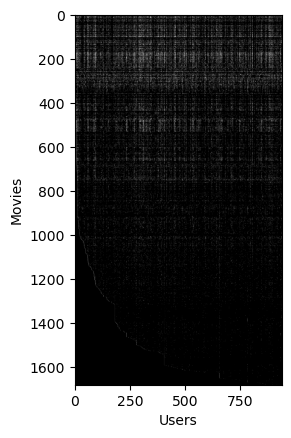

In [52]:
plt.imshow(Y,cmap='gray')
plt.xlabel('Users')
plt.ylabel('Movies');

In [53]:
print('Please enter the movie ratings(1-5 or 0 if not seen): \n')
userRatings=np.zeros((numMovies,1))

# Ask user ratings for set movies
indices=[1,98,7,12,55,64,66,69,183,225,355]
for index in indices:
    movie=movies.loc[index]
    try:
        question=f"{movie['Movie']} ({movie['Year']})"
        question=question.ljust(50)
        rating=float(input(question))
        if 1<=rating<=5:
            userRatings[int(index)-1]=rating
    except Exception as e:
        break

Please enter the movie ratings(1-5 or 0 if not seen): 



In [54]:
# Adding new user ratings 
Y=np.column_stack((userRatings,Y))
# Updating R with new user ratings
R=np.column_stack((np.zeros(numMovies),R))
indices=np.where(Y[:,0]!=0)[0]
R[indices,0]=1

In [55]:
# Normalize Ratings
Ymean=np.zeros((numMovies,1))
Ynorm=np.zeros(Y.shape)

for i in range(numMovies):
    idx=np.where(R[i,:]==1)
    Ymean[i]=Y[i,idx].mean()
    Ynorm[i,idx]=Y[i,idx]-Ymean[i]

Training Collaborative Filtering...


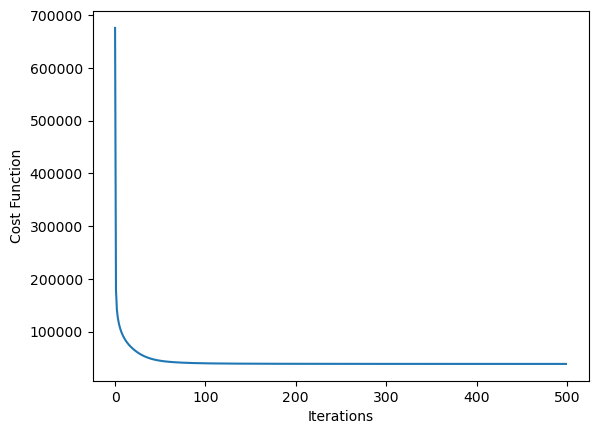

In [57]:
# Setting Initial Parameters
X=np.random.randn(numMovies,numFeatures)
theta=np.random.randn(numUsers,numFeatures)
initialParams=np.row_stack((X.reshape((-1,1)),theta.reshape((-1,1))))

# Setting Gradient descent options
lmbda=10
alpha=0.003
iterations=500

# Training Collaborative filtering
jHistory,params=regularizedGradientDescent(initialParams,Ynorm,R,numUsers,numMovies,numFeatures,lmbda,alpha,iterations)
# Unrolling the learned parameters into X and theta
X=params[:numMovies*numFeatures].reshape((numMovies,numFeatures))
theta=params[numMovies*numFeatures:].reshape((numUsers,numFeatures))

**After training the model, we can now make the predictions by computing the prediction matrix.**

In [60]:
P=np.dot(X,theta.T)
userPrediction=P[:,0]+Ymean.reshape(-1)

**For Original Ratings provided by the user :**

In [61]:
df=movies.copy()
df['User Ratings']=userRatings
df[df['User Ratings']!=0]

,Movie,Year,User Ratings
ID,,,


**Top 10 Recommended Movies are :**

In [62]:
limit=10
df=movies.copy()
df['Predicted Ratings']=userPrediction
df.sort_values(by=['Predicted Ratings'],ascending=False).head(limit)

,Movie,Year,Predicted Ratings
ID,,,
1189,Prefontaine,1997,5.0
1599,Someone Else's America,1995,5.0
814,"Great Day in Harlem, A",1994,5.0
1536,Aiqing wansui,1994,5.0
1500,Santa with Muscles,1996,5.0
1122,They Made Me a Criminal,1939,5.0
1201,Marlene Dietrich: Shadow and Light,1996,5.0
1653,Entertaining Angels: The Dorothy Day Story,1996,5.0
1467,"Saint of Fort Washington, The",1993,5.0
